Imports

In [7]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import metrics
from tqdm import tqdm

Load data

In [2]:
df = pd.read_csv("Auto.csv")
df["origin"] = df["origin"].astype("category")
df["horsepower"] = pd.to_numeric(df["horsepower"], errors="coerce")

df2 = df.copy()
df2["year"] = df2["year"].astype("category")

print(df.info())
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   mpg           397 non-null    float64 
 1   cylinders     397 non-null    int64   
 2   displacement  397 non-null    float64 
 3   horsepower    392 non-null    float64 
 4   weight        397 non-null    int64   
 5   acceleration  397 non-null    float64 
 6   year          397 non-null    int64   
 7   origin        397 non-null    category
 8   name          397 non-null    object  
dtypes: category(1), float64(4), int64(3), object(1)
memory usage: 25.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   mpg           397 non-null    float64 
 1   cylinders     397 non-null    int64   
 2   displacement  397 non-null    float64 
 3   ho

Linear Regression

In [3]:
def linear_regression(df, model_formula, seed=1):
    np.random.seed(seed)
    mask = np.random.rand(len(df)) < 0.8
    train_set = df[mask]
    valid_set = df[~mask]

    train_y, train_x = dmatrices(model_formula, data=train_set, return_type="dataframe")
    valid_y, valid_x = dmatrices(model_formula, data=valid_set, return_type="dataframe")

    start = time.time()
    model = sm.OLS(train_y, train_x)
    result = model.fit()
    end = time.time()

    train_y_pred = result.predict(train_x)
    valid_y_pred = result.predict(valid_x)
    train_mse = metrics.mean_squared_error(train_y, train_y_pred)
    valid_mse = metrics.mean_squared_error(valid_y, valid_y_pred)

    return result, (train_mse, valid_mse), end - start

Relationship between mpg and year

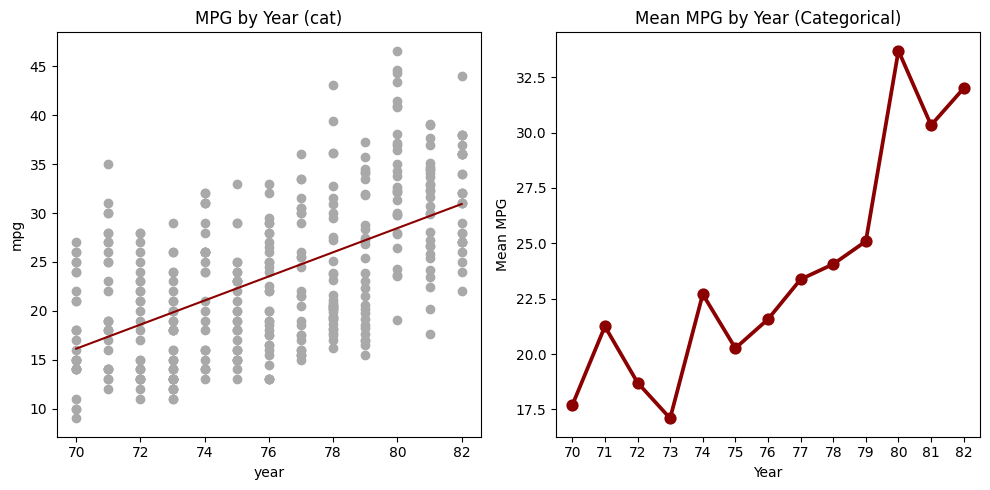

In [4]:
x = df["year"]
y = df["mpg"]

# # Analytical
# k = 2
# X_matrix = np.column_stack([x**i for i in range(k+1)])
# beta = np.matmul(
#     np.linalg.inv(np.matmul(X_matrix.transpose(), X_matrix)),
#     np.matmul(X_matrix.transpose(), y),
# )
# analytical_pred = sum([beta[i] * x**i for i in range(k+1)])

# OLS
k = 1
X_matrix = np.column_stack([x**i for i in range(k+1)])
model = sm.OLS(y, X_matrix)
result = model.fit()
ols_pred = result.predict(X_matrix)

fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.scatter(df["year"], df["mpg"], color="darkgrey")
plt.plot(x, ols_pred, color="darkred")
plt.xlabel("year")
plt.ylabel("mpg")
plt.title("MPG by Year (cat)")
fig.add_subplot(1, 2, 2)
mean_mpg_by_year = df2.groupby('year')['mpg'].mean().reset_index()
sns.pointplot(data=mean_mpg_by_year, x='year', y='mpg', color="darkred")
plt.xlabel('Year')
plt.ylabel('Mean MPG')
plt.title('Mean MPG by Year (Categorical)')
plt.tight_layout()
plt.show()

Comparison of models

In [8]:
result_continues, mse_continues, time_continues = 0, 0, 0
result_cat, mse_cat, time_cat = 0, 0, 0
reps = 1000

for _ in tqdm(range(reps)):
    res, mse, time_ = linear_regression(df, "mpg ~ year")
    result_continues = res
    mse_continues += mse[1]
    time_continues += time_
mse_continues /= reps
time_continues /= reps
for _ in tqdm(range(reps)):
    res, mse, time_ = linear_regression(df2, "mpg ~ year")
    result_cat = res
    mse_cat += mse[1]
    time_cat += time_
mse_cat /= reps
time_cat /= reps

print(result_continues.summary())
print(f"\033[91mval MSE : {mse_continues}\033[0m")
print(f"\033[94mTime : {time_continues}\033[0m")
print(result_cat.summary())
print(f"\033[91mval MSE : {mse_cat}\033[0m")
print(f"\033[94mTime : {time_cat}\033[0m")

100%|██████████| 1000/1000 [00:53<00:00, 18.78it/s]


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     179.5
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           1.32e-32
Time:                        18:51:18   Log-Likelihood:                -1019.0
No. Observations:                 312   AIC:                             2042.
Df Residuals:                     310   BIC:                             2050.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -73.8286      7.313    -10.096      0.0